In [1]:
import torch
import time
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:


device = (
    "cuda" if torch.cuda.is_available()
    else "mps"  if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")


# ## Data

Using device: cpu


In [3]:


DAE_np_data_path = 'data/np/npData.csv'

np_DAE_df = pd.read_csv(DAE_np_data_path)

In [4]:


np_DAE_df = np_DAE_df[np_DAE_df['author1'] != 'K.H.Hicks+'] # Dataset has multiple authors, we keep only B.K.Park+ to ensure only one target material...

In [5]:


df = np_DAE_df[['x2(eV)', 'x3(eV)', 'x4(deg)','y', 'dy']]

df = df.rename(columns={
    'x2(eV)': 'E_inc',
    'x3(eV)': 'E_sec',
    'x4(deg)': 'theta',
    'y': 'ddcs',  # double differential cross section
    'dy': 'Errddcs'  # Error on double differential cross section 

})
df = df.dropna(subset=['E_inc', 'E_sec', 'theta', 'ddcs'])

df = df[df['E_inc'] != 2.5e8]
import torch
import numpy as np
import pandas as pd


def prepare_experimental_data(df):

    # incident energy 
    E_inc_unique  = sorted(df['E_inc'].unique())

    # create the grid
    E_sec_unique  = np.asarray(sorted(df['E_sec'].unique()),  dtype=float)
    theta_unique  = np.asarray(sorted(df['theta'].unique()), dtype=float)

    # create the 2D distribution
    out = []
    for E_inc in E_inc_unique:
        # Sub-select rows for this incident energy
        sub = df[df['E_inc'] == E_inc]

        # Pivot into a full 2-D grid; reindex to guarantee rectangular shape
        grid = (
            sub.pivot(index='E_sec', columns='theta', values='ddcs')
               .reindex(index=E_sec_unique, columns=theta_unique)
               .fillna(0.0)
               .to_numpy()
        )

        out.append({
            'E_inc' : torch.tensor(E_inc,        dtype=torch.float32),
            'E_sec' : torch.tensor(E_sec_unique, dtype=torch.float32),
            'theta' : torch.tensor(theta_unique, dtype=torch.float32),
            'ddcs'  : torch.tensor(grid,         dtype=torch.float32)
        })

    return out
out = prepare_experimental_data(df)

# same as out, but cs are integrated over theta and E_sec
# This will give us the integrated results for each incident energy
integrated_results = []

for d in out:
    E_inc = d['E_inc']
    E_sec = d['E_sec']
    theta = d['theta']
    ddcs = d['ddcs']

    int_theta = torch.trapz(ddcs, theta, dim=1)  # integrate over theta
    int_Esec = torch.trapz(ddcs, E_sec, dim=0)  # integrate over E_sec

    integrated_results.append({
        'E_inc': E_inc,
        'E_sec': E_sec,
        'theta': theta,
        'int_over_theta': int_theta,
        'int_over_E_sec': int_Esec
    })



def plot_integrated_cross_sections(integrated_results):
    for data in integrated_results:
        E_inc = data['E_inc'].item()  # scalar float
        E_sec = data['E_sec'].numpy()
        theta = data['theta'].numpy()
        int_over_theta = data['int_over_theta'].numpy()
        int_over_E_sec = data['int_over_E_sec'].numpy()

        # Plot integrated over theta (cross section vs E_sec)
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plt.plot(E_sec, int_over_theta, marker='o')
        plt.xlabel('Secondary Energy $E_{sec}$')
        plt.ylabel('Integrated Cross Section (over θ)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        # Plot integrated over E_sec (cross section vs theta)
        plt.subplot(1, 2, 2)
        plt.plot(theta, int_over_E_sec, marker='o')
        plt.xlabel('Scattering Angle θ')
        plt.ylabel('Integrated Cross Section (over $E_{sec}$)')
        plt.title(f'Incident Energy $E_{{inc}}$ = {E_inc:.2f}')

        plt.tight_layout()
        plt.show()

# plot_integrated_cross_sections(integrated_results)


# ## Simulator

In [13]:
import math
import torch
import torch.nn as nn
from torch.autograd import Function

# ---------------------------
# Minimal NPReactionSimulator (batched only)
# ---------------------------
class NPReactionSimulator(nn.Module):
    def __init__(self, m_n=939.565, m_p=938.272, M_A=29785.0, S_n=7.70, S_p=13.46):
        super().__init__()
        self.register_buffer("m_n", torch.tensor(float(m_n)))
        self.register_buffer("m_p", torch.tensor(float(m_p)))
        self.register_buffer("M_A", torch.tensor(float(M_A)))
        self.register_buffer("S_n", torch.tensor(float(S_n)))
        self.register_buffer("S_p", torch.tensor(float(S_p)))

    def forward(self, Ek, r1, r2, r3):
        # Ek: (B,) or (B,1) -> expand to (B, N)
        if Ek.dim() == 1:
            Ek = Ek.unsqueeze(1).expand(-1, r1.shape[1])
        elif Ek.shape[1] == 1:
            Ek = Ek.expand(-1, r1.shape[1])

        m_n, m_p, M_A, S_n, S_p = (
            self.m_n.to(Ek),
            self.m_p.to(Ek),
            self.M_A.to(Ek),
            self.S_n.to(Ek),
            self.S_p.to(Ek)
        )

        denom = (M_A + m_n) ** 2
        Tk = (Ek ** 2) * m_n / (denom + 1e-12)
        Ex = Ek - Tk + S_n
        available_E = Ex - S_p
        mask = available_E > 0

        Ep_com = r1 * available_E

        # Ep_com = 0.1 * available_E + 0.9 * r1 * available_E
        E_p_com = Ep_com + m_p
        p_mag_com = torch.sqrt(torch.clamp(E_p_com**2 - m_p**2, min=0.0))

        cos_theta_com = 2.0 * r2 - 1.0  # r2 in [0, 1] -> cos(theta) in [-1, 1]
        sin_theta_com = torch.sqrt(torch.clamp(1.0 - cos_theta_com**2, min=0.0))
        phi = 2.0 * torch.pi * r3  # r3 in [0, 1] -> phi in [0, 2π] 

        px_com = p_mag_com * sin_theta_com * torch.cos(phi)
        py_com = p_mag_com * sin_theta_com * torch.sin(phi)
        pz_com = p_mag_com * cos_theta_com

        M_recoil = M_A + m_n
        beta = torch.clamp(Tk / (M_recoil + 1e-12), max=0.999999)
        gamma = 1.0 / torch.sqrt(torch.clamp(1.0 - beta**2, min=1e-12))

        E_lab = gamma * (E_p_com + beta * pz_com)
        pz_lab = gamma * (pz_com + beta * E_p_com)
        p_mag_lab = torch.sqrt(px_com**2 + py_com**2 + pz_lab**2 + 1e-12)

        Ep_lab = torch.where(mask, E_lab - m_p, torch.zeros_like(E_lab))
        cos_theta_lab = torch.where(mask, pz_lab / (p_mag_lab + 1e-12), torch.zeros_like(pz_lab))
        return Ep_lab, cos_theta_lab


# ---------------------------
# Differentiable Histogram (much simpler and more stable than KDE)
# ---------------------------
# class DifferentiableHistogram(nn.Module):
#     def __init__(self, bin_edges, normalize=True):
#         super().__init__()
#         self.register_buffer("bin_edges", bin_edges.view(-1))
#         self.normalize = bool(normalize)
#         self.n_bins = len(bin_edges) - 1
        
#     def forward(self, samples, weights=None):
#         # samples: (B, N)
#         B, N = samples.shape
        
#         if weights is None:
#             weights = torch.ones_like(samples)
        
#         # Create histogram using soft binning for differentiability
#         bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:]) / 2
#         bin_width = self.bin_edges[1] - self.bin_edges[0]  # Assume uniform bins
        
#         # Soft assignment to bins using sigmoid
#         # For each sample, compute soft membership to each bin
#         samples_expanded = samples.unsqueeze(-1)  # (B, N, 1)
#         bin_centers_expanded = bin_centers.view(1, 1, -1)  # (1, 1, n_bins)


                
#         tau = getattr(self, "tau", None)
#         if tau is None:
#             tau = 2.0 * bin_width      # start soft; (larger tau -> softer)
#         distances = torch.abs(samples_expanded - bin_centers_expanded)
#         soft_assignments = torch.sigmoid((bin_width/2 - distances) / (tau + 1e-12))
                
#         # Weight by sample weights
#         weights_expanded = weights.unsqueeze(-1)  # (B, N, 1)
#         weighted_assignments = soft_assignments * weights_expanded  # (B, N, n_bins)
        
#         # Sum over samples to get histogram
#         histogram = weighted_assignments.sum(dim=1)  # (B, n_bins)
        
#         if self.normalize:
#             total_weight = weights.sum(dim=1, keepdim=True).clamp(min=1e-8)
#             histogram = histogram / total_weight
        
#         return histogram

class DifferentiableHistogram(nn.Module):
    def __init__(self, bin_centers, normalize=True, tau=None):
        """
        Differentiable histogram using bin centers only (uniform bins).
        
        Args:
            bin_centers (Tensor): (n_bins,) tensor of bin centers.
            normalize (bool): whether to normalize counts per batch.
            tau (float or None): softness parameter. Larger -> softer.
                                 If None, defaults to 2 * bin_width.
        """
        super().__init__()
        bin_centers = bin_centers.view(-1)
        self.register_buffer("bin_centers", bin_centers)
        self.n_bins = len(bin_centers)

        # infer bin width from spacing of centers (assume uniform bins)
        if self.n_bins > 1:
            bin_width = bin_centers[1] - bin_centers[0]
        else:
            raise ValueError("At least 2 bin centers are required to infer bin width.")
        
        self.bin_width = float(bin_width)
        self.normalize = bool(normalize)
        self.tau = tau if tau is not None else 2.0 * self.bin_width

    def forward(self, samples, weights=None):
        """
        Args:
            samples (Tensor): (B, N) batch of sample values
            weights (Tensor or None): (B, N) sample weights
        Returns:
            Tensor: (B, n_bins) differentiable histogram
        """
        B, N = samples.shape

        if weights is None:
            weights = torch.ones_like(samples)

        # Expand dims for broadcasting
        samples_expanded = samples.unsqueeze(-1)  # (B, N, 1)
        bin_centers_expanded = self.bin_centers.view(1, 1, -1)  # (1, 1, n_bins)

        # Soft assignment based on distance to bin centers
        distances = torch.abs(samples_expanded - bin_centers_expanded)
        soft_assignments = torch.sigmoid((self.bin_width/2 - distances) / (self.tau + 1e-12))

        # Apply weights
        weights_expanded = weights.unsqueeze(-1)  # (B, N, 1)
        weighted_assignments = soft_assignments * weights_expanded  # (B, N, n_bins)

        # Aggregate into histogram
        histogram = weighted_assignments.sum(dim=1)  # (B, n_bins)

        if self.normalize:
            total_weight = weights.sum(dim=1, keepdim=True).clamp(min=1e-8)
            histogram = histogram / total_weight

        return histogram

# ---------------------------
# Minimal Pipeline
# ---------------------------
class ACSPipeline(nn.Module):
    def __init__(self, cos_theta_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        # self.histogram = DifferentiableHistogram(bin_edges=cos_theta_bins, normalize=True)
        self.histogram = DifferentiableHistogram(bin_centers=cos_theta_bins, normalize=True)


    def forward(self, Ek, r1, r2, r3):
        Ep_lab, cos_theta_lab = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(cos_theta_lab, weights=valid)
    
class ECSPipeline(nn.Module):
    def __init__(self, E_bins):
        super().__init__()
        self.simulator = NPReactionSimulator()
        self.histogram = DifferentiableHistogram(bin_edges=E_bins, normalize=True)

    def forward(self, Ek, r1, r2, r3):
        Ep_lab, _ = self.simulator(Ek, r1, r2, r3)
        valid = (Ep_lab > 0).float()
        return self.histogram(Ep_lab, weights=valid)
    


# ## Network

In [26]:


import torch
import torch.nn as nn
import torch.nn.functional as F


def get_device():
    return torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda" if torch.cuda.is_available() else "cpu")

def safe_logit(u, eps=1e-6):
    u = u.clamp(min=eps, max=1.0 - eps)
    return torch.log(u) - torch.log1p(-u)

def make_feature_stack(d_in, n_hidden, n_layers):
    layers, d = [], d_in
    for _ in range(n_layers):
        layers += [nn.Linear(d, n_hidden)]
        layers += [nn.LayerNorm(n_hidden)]
        layers += [nn.ReLU()]
        d = n_hidden
    return nn.Sequential(*layers), d

class UniformPreservingMLP(nn.Module):
    """
    Maps [u, λ] -> y in [0,1]^n_out via y = sigmoid(Δ([u,λ]) + logit(u)).
    At init, Δ ≡ 0  => y = u (uniform preserved).
    """
    def __init__(self, n_in, n_lamda, n_hidden, n_layers, n_out=None, eps_logit=1e-6):
        super().__init__()
        if n_out is None:
            n_out = n_in
        assert n_out <= n_in
        self.n_in = n_in
        self.n_lam = n_lamda
        self.n_out = n_out
        self.eps_logit = eps_logit

        self.feats, d_last = make_feature_stack(n_in + n_lamda, n_hidden, n_layers)
        self.head = nn.Linear(d_last, n_out)
        self._init_weights()

    def l1_penalty(self):
        return self.head.weight.abs().sum()

    def _init_weights(self):
        for m in self.feats.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0.0, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        # Head: small random init instead of zeros
        nn.init.normal_(self.head.weight, mean=0.0, std=1e-3)
        if self.head.bias is not None:
            nn.init.zeros_(self.head.bias)

    def forward(self, x):
        u = x[..., :self.n_in]
        lam = x[..., self.n_in:self.n_in + self.n_lam]
        h = self.feats(torch.cat([u, lam], dim=-1))
        delta = self.head(h)
        u_head = u[..., :self.n_out]
        z = delta + safe_logit(u_head, eps=self.eps_logit)
        return torch.sigmoid(z)


In [25]:
import torch
import torch.nn as nn

def mse_loss_with_stability(sim, exp, eps=1e-8):
    """
    MSE loss with numerical stability, without normalization
    (since cross-sections don't need to be normalized)
    """
    # Clamp to avoid numerical issues
    sim = torch.clamp(sim, min=eps)
    exp = torch.clamp(exp, min=eps)
    
    # Simple MSE
    mse_loss = torch.mean((sim - exp) ** 2)
    
    return mse_loss

def relative_mse_loss(sim, exp, eps=1e-8):
    """
    Relative MSE loss - useful when cross-sections span many orders of magnitude
    """
    exp_safe = torch.clamp(torch.abs(exp), min=eps)
    relative_error = (sim - exp) / exp_safe
    return torch.mean(relative_error ** 2)

class BatchInterpolationLoss(nn.Module):
    """
    Improved batch-optimized interpolation loss
    """
    
    def __init__(self, exp_theta_degrees, loss_type='mse'):
        super().__init__()
        self.register_buffer('exp_cos_theta', torch.cos(torch.deg2rad(exp_theta_degrees)))
        self.loss_type = loss_type
    
    def differentiable_interp1d(self, x, y, x_new):
        """
        Improved batch interpolation with better dimension handling
        """
        # Clamp interpolation points to valid range
        x_new_clamped = torch.clamp(x_new, x.min(), x.max())
        
        # Find indices for interpolation
        indices = torch.searchsorted(x, x_new_clamped, right=False)
        indices = torch.clamp(indices, 1, len(x) - 1)
        
        # Get surrounding points
        x0 = x[indices - 1]
        x1 = x[indices]
        
        # Handle batch dimension properly
        if y.dim() == 2:  # (batch_size, n_sim)
            y0 = y[:, indices - 1]
            y1 = y[:, indices]
            # Expand x coordinates to match batch dimension
            alpha = ((x_new_clamped.unsqueeze(0) - x0.unsqueeze(0)) / 
                    (x1.unsqueeze(0) - x0.unsqueeze(0)))
        else:  # 1D case
            y0 = y[indices - 1]
            y1 = y[indices]
            alpha = (x_new_clamped - x0) / (x1 - x0)
            
        # Linear interpolation
        result = y0 + alpha * (y1 - y0)
        return result
    
    def forward(self, sim_cos_theta, sim_dsigma, exp_dsigma):
        """
        Args:
            sim_cos_theta: (n_sim,) simulation grid (assumed sorted)
            sim_dsigma: (batch_size, n_sim) simulated cross sections
            exp_dsigma: (batch_size, n_exp) experimental cross sections
        """
        # Interpolate simulation to experimental points
        sim_at_exp_points = self.differentiable_interp1d(
            sim_cos_theta, sim_dsigma, self.exp_cos_theta
        )
        
        # Choose loss function
        if self.loss_type == 'mse':
            return mse_loss_with_stability(sim_at_exp_points, exp_dsigma)
        elif self.loss_type == 'relative_mse':
            return relative_mse_loss(sim_at_exp_points, exp_dsigma)
        elif self.loss_type == 'normalized_mse':
            return mse_normalized_loss(sim_at_exp_points, exp_dsigma)
        elif self.loss_type == 'variance':
            return variance_based_loss(sim_at_exp_points, exp_dsigma)
        elif self.loss_type == 'log':
            return log_loss(sim_at_exp_points, exp_dsigma)
        else:
            raise ValueError(f"Unknown loss type: {self.loss_type}")

# Alternative loss functions
def variance_based_loss(sim, exp):
    """
    Your proposed variance-based loss: <d²> - <d>²
    where d = y_exp - y_sim_interp
    """
    residuals = exp - sim  # d = y_exp - y_sim_interp
    
    # <d²> - mean of squared residuals
    mean_squared_residuals = torch.mean(residuals ** 2)
    
    # <d>² - square of mean residuals  
    mean_residuals_squared = torch.mean(residuals) ** 2
    
    # Variance of residuals
    variance_loss = mean_squared_residuals - mean_residuals_squared
    
    return variance_loss

def log_loss(sim, exp, eps=1e-8):
    """
    Log-based loss - good for cross-sections spanning many orders of magnitude
    """
    sim_safe = torch.clamp(sim, min=eps)
    exp_safe = torch.clamp(exp, min=eps)
    
    log_sim = torch.log(sim_safe)
    log_exp = torch.log(exp_safe)
    
    return torch.mean((log_sim - log_exp) ** 2)

# Your original normalized loss (kept for completeness)
def mse_normalized_loss(sim, exp, eps=1e-8):
    """
    MSE loss with normalization - use only if you want to treat as distributions
    """
    sim = torch.clamp(sim, min=eps)
    exp = torch.clamp(exp, min=eps)
    
    sim_sum = sim.sum(dim=-1, keepdim=True)
    exp_sum = exp.sum(dim=-1, keepdim=True)
    
    sim_norm = sim / (sim_sum + eps)
    exp_norm = exp / (exp_sum + eps)
    
    mse_loss = torch.mean((sim_norm - exp_norm) ** 2)
    sparsity_penalty = 1e-6 * torch.mean(sim)
    
    return mse_loss + sparsity_penalty

In [ ]:


# ------------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------------
n_in        = 3       # number of parameters, i.e., random numbers needed in the simulation
n_lamda     = 1       # number of untrainable external parameter dependencies
n_hidden    = 32      # number of hidden neurons in the network, at each layer
n_layers    = 5       # number of hidden layers in the network (reduced for faster training)
n_out       = n_in    # must match the number of output parameters
batch_size  = 40      # samples of random number per batch, to build the distribution. Larger is better, but slower
n_mc_samples = 5_000  # reduced for faster training
epochs      = 4_000    # number of epochs to train the network
lr          = 1e-3    # learning rate for the optimizer
l1_lambda   = 1e-3  # L1 regularization strength


print("Using UniformPreservingMLP")
net = UniformPreservingMLP(n_in, n_lamda, n_hidden, n_layers, n_out).to(device)

optimiser = optim.Adam(net.parameters(), lr=lr)

# Maybe AdamW?
# optimiser = optim.AdamW(net.parameters(), lr=lr, weight_decay=1e-5)????

# Scheduler to reduce learning rate on plateau
# This will reduce the learning rate if the loss does not improve for a certain number of epochs
# It helps to avoid overshooting the minimum and allows for finer convergence
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser, mode='min', factor=0.2, patience=300, min_lr=1e-5) #, verbose=True)
# ------------------------------------------------------------------


# ## Training

Using UniformPreservingMLP


In [31]:
def create_full_range_grid_with_exp_points(n_total_points=499, exp_theta_degrees=None):
    """
    Create a cos(theta) grid covering full range [-1,1] but ensuring 
    experimental points are exactly included
    
    Args:
        n_total_points: Total number of grid points
        exp_theta_degrees: Experimental angles in degrees (e.g., [1,3,5,7,9,11,13])
    
    Returns:
        cos_theta_bins: Full range grid with experimental points included
    """
    if exp_theta_degrees is None:
        exp_theta_degrees = torch.tensor([1, 3, 5, 7, 9, 11, 13], dtype=torch.float32)
    
    # Convert experimental angles to cos(theta)
    exp_cos_theta = torch.cos(torch.deg2rad(exp_theta_degrees))
    
    #DEBUG:
    # print(f"Experimental angles: {exp_theta_degrees.numpy()}")
    # print(f"Experimental cos(theta): {exp_cos_theta.numpy()}")
    
    # Create base grid with slightly fewer points to make room for experimental points
    n_base = n_total_points - len(exp_cos_theta)
    base_grid = torch.linspace(-1.0, 1.0, n_base)
    
    # Combine base grid with experimental points
    all_points = torch.cat([base_grid, exp_cos_theta])
    
    # Remove duplicates and sort
    unique_points = torch.unique(all_points)
    sorted_points = torch.sort(unique_points)[0]
    
    #DEBUG: 
    # print(f"Grid created: {len(sorted_points)} points (target was {n_total_points})")
    # print(f"Grid range: [{sorted_points.min():.6f}, {sorted_points.max():.6f}] (cos(theta) space)")
    # print(f"Grid range: [{torch.rad2deg(torch.acos(sorted_points.max())):.1f}°, {torch.rad2deg(torch.acos(sorted_points.min())):.1f}°] (angle space)")
    
    return sorted_points



In [32]:


from tqdm import trange
import matplotlib.pyplot as plt

# ---------------------------
# Create ACS/ECS simulation layer (autograd-friendly)
# ---------------------------
# E_inc_unique = torch.tensor(sorted(df['E_inc'].unique()), dtype=torch.float32) / 1e6

# E_sec_exp = torch.tensor(sorted(df['E_sec'].unique()), dtype=torch.float32) / 1e6
# cos_theta_exp = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)

# Create bin edges from experimental data points
# cos_theta_bins = torch.linspace(cos_theta_exp.min(), cos_theta_exp.max(), len(cos_theta_exp) + 1)

# theta_bins = torch.linspace(0,180, 500)
# cos_theta_edges = torch.cos(torch.deg2rad(theta_bins))
# cos_theta_bins = 0.5 * (cos_theta_edges[:-1] + cos_theta_edges[1:])  # shape (720,)

cos_theta_exp = torch.tensor([1, 3, 5, 7, 9, 11, 13], dtype=torch.float32)
cos_theta_bins = create_full_range_grid_with_exp_points(800, cos_theta_exp)

# E_sec_bins = torch.linspace(E_sec_exp.min(), E_sec_exp.max(), len(E_sec_exp) + 1)

# Prep experimental data
all_Ek = torch.stack([res['E_inc'] for res in integrated_results]) / 1e6 # (N,)

all_exp = torch.stack([res['int_over_E_sec'] for res in integrated_results])  # (N, M)
# all_exp = torch.stack([res['int_over_theta'] for res in integrated_results])  # (N, M)

all_Ek = all_Ek.to(device)
all_exp = all_exp.to(device)
num_samples_total = all_Ek.shape[0]

acs_pipeline = ACSPipeline(cos_theta_bins=cos_theta_bins).to(device)
# ecs_pipeline = ECSPipeline(E_bins=E_sec_bins).to(device)

acs_pipeline.histogram.tau = 2.0 * (cos_theta_bins[1]-cos_theta_bins[0]).item()
# ecs_pipeline.histogram.tau = 2.0 * (E_sec_bins[1]-E_sec_bins[0]).item()

# -------------
# Training loop with better tracking
# -------------

# Track losses
loss_history = []
# mse_loss_history = []
# L1_loss_history = []
epoch_history = []

# ==== Debug toggles ====
USE_FIXED_IDX = False         # True = always use the same idx for Ek
FIXED_IDX_VALUE = 0          # which dataset entry to use if above is True
USE_FIXED_MC = False         # True = use the same MC samples each epoch

# Prepare fixed MC samples if needed
if USE_FIXED_MC:
    fixed_uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

net.train()
print("Starting training...")
print(f"Initial learning rate: {lr}")

for epoch in trange(epochs, desc='Training Epochs'):

    # ----- Index selection -----
    if USE_FIXED_IDX:
        idx = torch.full((batch_size,), FIXED_IDX_VALUE, dtype=torch.long, device=device)
    else:
        idx = torch.randint(0, num_samples_total, (batch_size,), device=device)

    Ek_batch = all_Ek[idx] / 1e3         # (B,)
    dsigma_dOmega_exp = all_exp[idx] # (B, M)

    # ----- MC samples -----
    if USE_FIXED_MC:
        uniform_samples = fixed_uniform_samples
    else:
        uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

    # ----- Network forward -----
    Ek_expanded = Ek_batch[:, None, None].expand(-1, n_mc_samples, 1)  # (B, N, 1)
    net_input = torch.cat([uniform_samples, Ek_expanded], dim=-1)       # (B, N, n_in + 1)
    net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten
    t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)
    t = t.clamp(1e-6, 1 - 1e-6)


    r1 = t[:, :, 0]
    r2 = t[:, :, 1]
    r3 = t[:, :, 2]

    # ----- ACS forward pass -----
    dsigma_dOmega_sim = acs_pipeline(Ek_batch * 1e3, r1, r2, r3)  # (B, M)
   

    # # ----- Simple MSE Loss (no extra scaling) -----
    # # mse_loss = mse_normalized_loss(dsigma_dOmega_sim, dsigma_dOmega_exp)
    # mse_loss = mse_normalized_loss(sim_binned, dsigma_dOmega_exp)
    # # l1_loss = l1_lambda * net.l1_penalty()
    # # Combine losses    
    # loss = mse_loss #+ l1_loss
    # loss = mse_normalized_loss(dsigma_dOmega_sim, dsigma_dOmega_exp) + l1_lambda * net.l1_penalty()

    # Choose loss function based on your preference:
    # 'mse', 'relative_mse', 'normalized_mse', 'variance', 'log'
    batch_loss_fn = BatchInterpolationLoss(cos_theta_exp, loss_type='normalized_mse').to(device)
    loss = batch_loss_fn(cos_theta_bins, dsigma_dOmega_sim, dsigma_dOmega_exp)

    # must require grad
    assert loss.requires_grad, "Loss got detached — check loss path for item()/detach()/no_grad."

    # ----- Backprop -----
    optimiser.zero_grad(set_to_none=True)
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
    optimiser.step()

    scheduler.step(loss.detach())


    if (epoch+1) % 50 == 0:
        # decay toward near-hard bins, but not too hard
        acs_pipeline.histogram.tau = max(0.20 * float(cos_theta_bins[1]-cos_theta_bins[0]),
                                        acs_pipeline.histogram.tau * 0.7)
        # ecs_pipeline.histogram.tau = max(0.20 * float(E_sec_bins[1]-E_sec_bins[0]),
        #                                 ecs_pipeline.histogram.tau * 0.7)

    # Track loss AFTER backward (detach here is fine)
    loss_history.append(float(loss.detach()))
    # mse_loss_history.append(float(mse_loss.detach()))
    # L1_loss_history.append(float(l1_loss.detach()))
    epoch_history.append(epoch)



    if epoch % 100 == 0:
        # Calculate gradient norm
        total_grad_norm = 0
        for p in net.parameters():
            if p.grad is not None:
                total_grad_norm += p.grad.norm().item() ** 2
        total_grad_norm = total_grad_norm ** 0.5
        
        print(f"Epoch {epoch+1:3d} | Loss (TOT): {loss.detach().item():.6f} | "
            #   f"Loss (MSE): {mse_loss.detach().item():.6f} | "
            #   f"Loss (L1): {l1_loss.detach().item():.6f} | "
              f"Grad Norm: {total_grad_norm:.6e} | "
              f"Sim sum: {dsigma_dOmega_sim.sum().item():.4f} | "
              f"Exp sum: {dsigma_dOmega_exp.sum().item():.4f} | "
              f"LR: {optimiser.param_groups[0]['lr']:.1e}")
        
        
        


Starting training...
Initial learning rate: 0.001


Training Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

Training Epochs:   0%|          | 1/1000 [00:00<12:43,  1.31it/s]

Epoch   1 | Loss (TOT): 0.003018 | Grad Norm: 1.961165e-03 | Sim sum: 132.7434 | Exp sum: 20159.8574 | LR: 1.0e-03


Training Epochs:  10%|█         | 101/1000 [02:26<22:03,  1.47s/it]

Epoch 101 | Loss (TOT): 0.002030 | Grad Norm: 4.348297e-03 | Sim sum: 79.1523 | Exp sum: 19197.2637 | LR: 1.0e-03


Training Epochs:  20%|██        | 201/1000 [04:55<19:37,  1.47s/it]

Epoch 201 | Loss (TOT): 0.000570 | Grad Norm: 2.456672e-03 | Sim sum: 57.1436 | Exp sum: 21099.5469 | LR: 1.0e-03


Training Epochs:  30%|███       | 301/1000 [07:05<14:16,  1.23s/it]

Epoch 301 | Loss (TOT): 0.000569 | Grad Norm: 4.439997e-03 | Sim sum: 50.3620 | Exp sum: 19339.4707 | LR: 1.0e-03


Training Epochs:  40%|████      | 401/1000 [08:38<05:58,  1.67it/s]

Epoch 401 | Loss (TOT): 0.000392 | Grad Norm: 2.507993e-03 | Sim sum: 53.1434 | Exp sum: 20743.4395 | LR: 1.0e-03


Training Epochs:  50%|█████     | 501/1000 [09:40<04:55,  1.69it/s]

Epoch 501 | Loss (TOT): 0.000371 | Grad Norm: 5.267403e-03 | Sim sum: 57.1230 | Exp sum: 19074.0840 | LR: 1.0e-03


Training Epochs:  60%|██████    | 601/1000 [10:39<03:59,  1.67it/s]

Epoch 601 | Loss (TOT): 0.000225 | Grad Norm: 5.815446e-03 | Sim sum: 58.9929 | Exp sum: 20154.2773 | LR: 1.0e-03


Training Epochs:  70%|███████   | 701/1000 [11:39<02:59,  1.67it/s]

Epoch 701 | Loss (TOT): 0.000129 | Grad Norm: 9.762782e-03 | Sim sum: 61.9220 | Exp sum: 19949.2188 | LR: 1.0e-03


Training Epochs:  80%|████████  | 801/1000 [13:32<04:31,  1.36s/it]

Epoch 801 | Loss (TOT): 0.000152 | Grad Norm: 4.020010e-03 | Sim sum: 61.3611 | Exp sum: 19609.7070 | LR: 1.0e-03


Training Epochs:  90%|█████████ | 901/1000 [15:48<02:14,  1.36s/it]

Epoch 901 | Loss (TOT): 0.000153 | Grad Norm: 2.190848e-02 | Sim sum: 61.5860 | Exp sum: 19819.3320 | LR: 1.0e-03


Training Epochs: 100%|██████████| 1000/1000 [17:43<00:00,  1.06s/it]



=== TRAINING COMPLETE ===
Final loss: 0.000098
Initial loss: 0.003018
Loss improvement: 0.002920


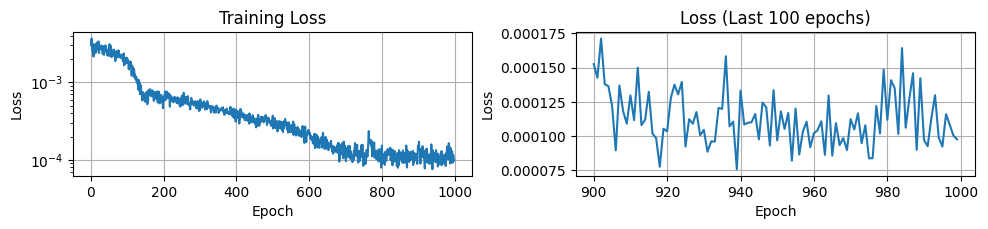

In [33]:
print("\n=== TRAINING COMPLETE ===")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"Initial loss: {loss_history[0]:.6f}")
print(f"Loss improvement: {loss_history[0] - loss_history[-1]:.6f}")

# Plot loss curve
plt.figure(figsize=(10, 6))
plt.subplot(3, 2, 1)
plt.plot(epoch_history, loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.yscale('log')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot(epoch_history[-100:], loss_history[-100:])  # Last 100 epochs
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (Last 100 epochs)')
plt.grid(True)

##########

# plt.subplot(3, 2, 3)
# plt.plot(epoch_history, mse_loss_history)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('MSE Training Loss')
# plt.yscale('log')
# plt.grid(True)

# plt.subplot(3, 2, 4)
# plt.plot(epoch_history[-100:], mse_loss_history[-100:])  # Last 100 epochs
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('MSE Loss (Last 100 epochs)')
# plt.grid(True)

##########

# plt.subplot(3, 2, 5)
# plt.plot(epoch_history, L1_loss_history)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('L1 Training Loss')
# plt.yscale('log')
# plt.grid(True)

# plt.subplot(3, 2, 6)
# plt.plot(epoch_history[-100:], L1_loss_history[-100:])  # Last 100 epochs
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('L1 Loss (Last 100 epochs)')
# plt.grid(True)

plt.tight_layout()
plt.show()

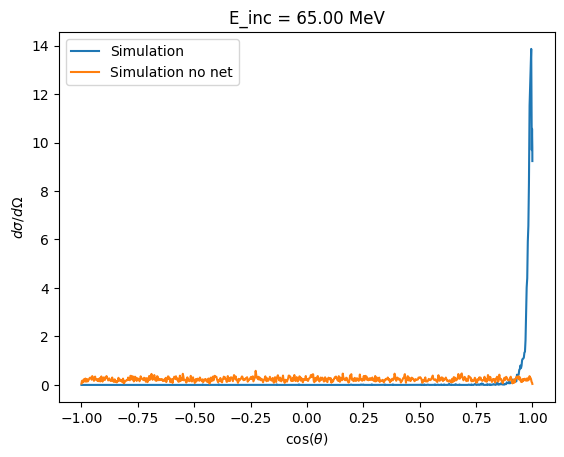

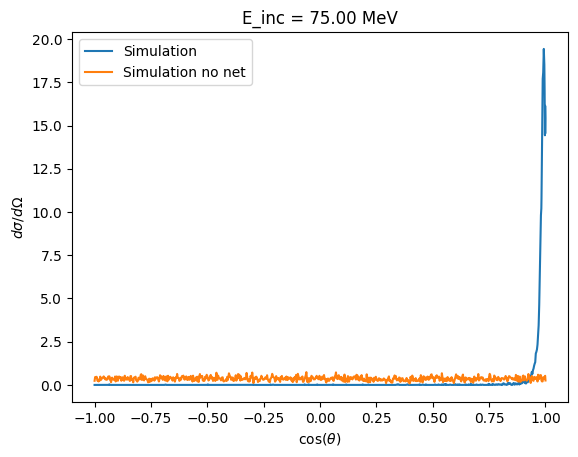

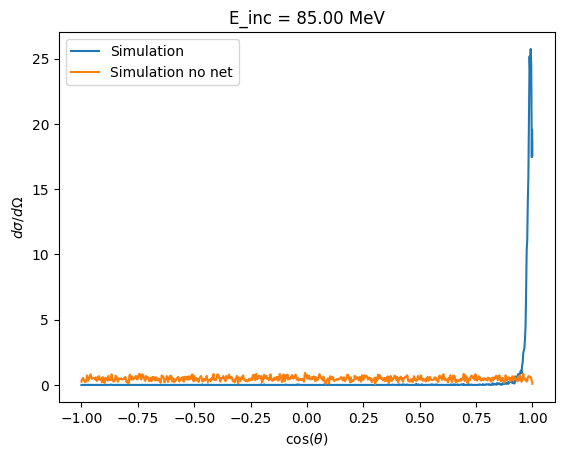

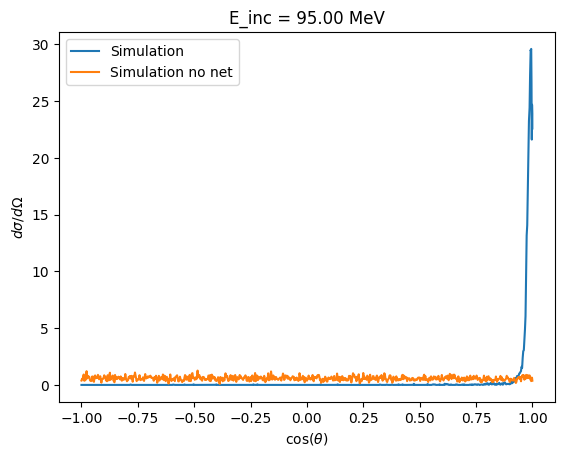

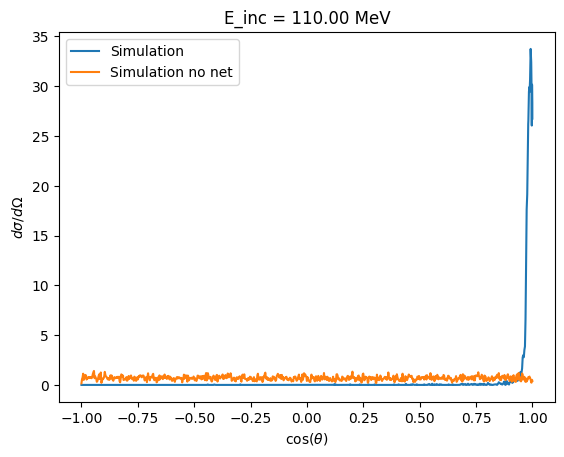

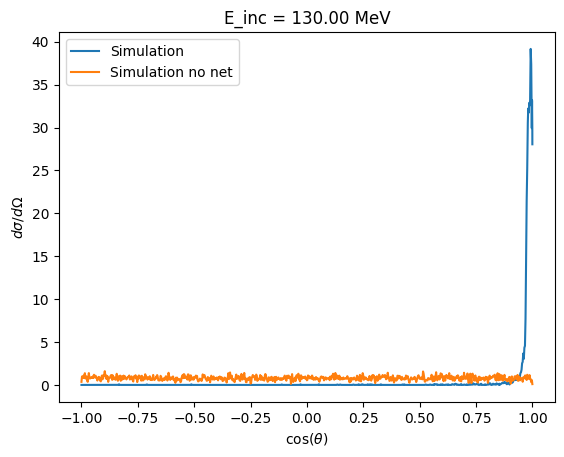

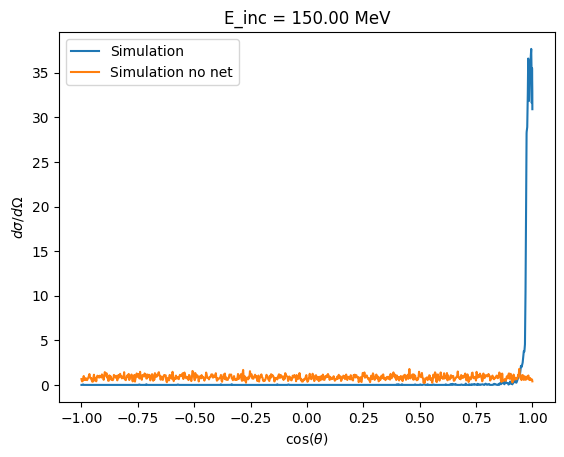

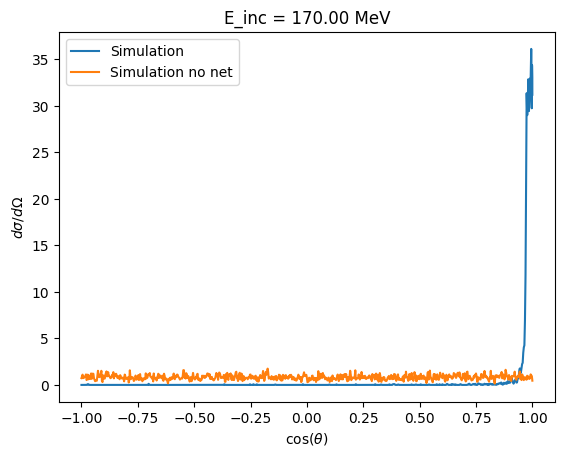

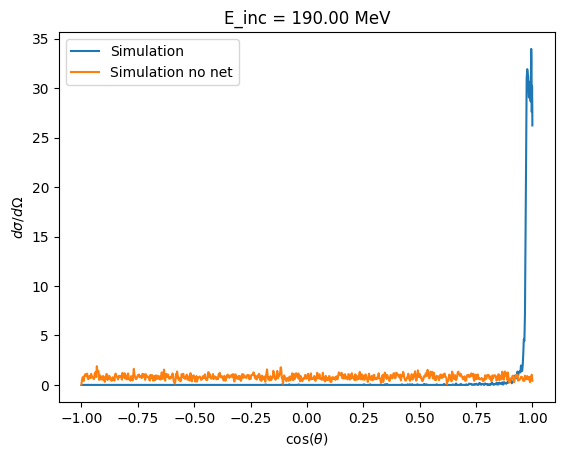

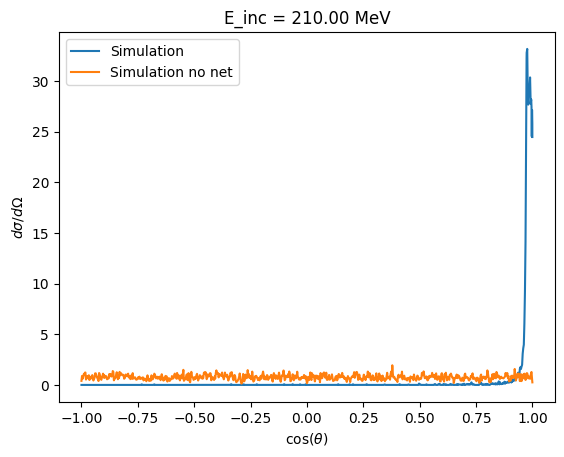

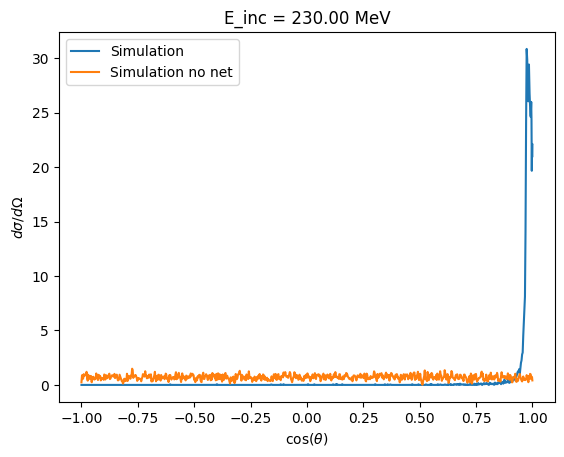

In [ ]:



import torch
import matplotlib.pyplot as plt

net.eval()

n_mc_samples = 5_000
monitor_indices = range(len(integrated_results))  # pick a few energies


for idx in monitor_indices:
    # Experimental values
    Ek_val = integrated_results[idx]['E_inc'] / 1e6 / 1e3 # scalar tensor

    exp_dist = integrated_results[idx]['int_over_E_sec'].to(device)  # (M,)
    # exp_dist = integrated_results[idx]['int_over_theta'].to(device)  # (M,)

    # Shape (B=1, N) for Monte Carlo
    Ek_batch = Ek_val.unsqueeze(0).to(device)  # (1,)
    Ek_expanded = Ek_batch.unsqueeze(1).expand(-1, n_mc_samples)  # (1, N)

    # Random latent samples: (B=1, N, n_in)
    uniform_samples = torch.rand((1, n_mc_samples, n_in), device=device)

    # u1 = uniform_samples[..., 0] 
    # u2 = uniform_samples[..., 1]   
    # u3 = uniform_samples[..., 2]   

    # Append Ek to each MC sample row: (1, N, n_in+1)
    net_input = torch.cat([uniform_samples, Ek_expanded.unsqueeze(-1)], dim=-1)

    # Flatten for net: (B*N, n_in+1)
    net_input_flat = net_input.reshape(-1, n_in + 1)

    with torch.no_grad():
        t = net(net_input_flat).reshape(1, n_mc_samples, n_in)
        r1 = t[:, :, 0]
        r2 = t[:, :, 1]
        r3 = t[:, :, 2] 

        # Now acs_pipeline gets (B=1, N) inputs for r1, r2, r3
        sim_dist = acs_pipeline(Ek_batch * 1e3, r1, r2, r3).squeeze(0)  # (M,)
        # print(sim_dist.shape, cos_theta_bins.shape)
        sim_dist = sim_dist * exp_dist.sum() / (sim_dist.sum() + 1e-8)  # Normalize to match experimental scale
        # sim_dist = ecs_pipeline(Ek_batch, r1, r2, r3).squeeze(0)  # (M,)

        # sim_dist_nonet = acs_pipeline(Ek_batch * 1e3, u1, u2, u3).squeeze(0)  # (M,)
        # sim_dist_nonet = sim_dist_nonet * exp_dist.sum() / (sim_dist_nonet.sum() + 1e-8)  # Normalize to match experimental scale

    cos_theta_exp_plot = torch.tensor(sorted(np.cos(np.radians(df['theta'].unique()))), dtype=torch.float32)
    # Plot
    plt.figure()
    plt.plot(cos_theta_exp_plot.cpu(), exp_dist.cpu(), label='Experimental')
    plt.plot(cos_theta_bins.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.plot(cos_theta_bins.cpu(), sim_dist_nonet.cpu(), label='Simulation no net')
    plt.xlabel(r'$\cos(\theta)$')
    # plt.xlim(cos_theta_exp_plot.min(), cos_theta_exp_plot.max())

    # plt.plot(E_sec_exp.cpu(), exp_dist.cpu(), label='Experimental')
    # plt.plot(E_sec_exp.cpu(), sim_dist.cpu(), label='Simulation')
    # plt.xlabel(r'$E_{\text{sec}}$ [MeV]')
    
    plt.ylabel(r'$d\sigma/d\Omega$')
    plt.title(f'E_inc = {(Ek_val.item() * 1e3):.2f} MeV')
    plt.legend()
    plt.show()


# ## Testing

In [43]:


Ek_batch = torch.tensor([[[0.095] for m in range(n_mc_samples)] for b in range(batch_size)], device=device)  # Example incident energies in MeV, one for each batch

uniform_samples = torch.rand((batch_size, n_mc_samples, n_in), device=device)

# ----- Network forward -----


net_input = torch.cat([uniform_samples, Ek_batch/100], dim=-1)       # (B, N, n_in + 1)

print("Shape of net_input before flattening:", net_input.shape)

net_input_flat = net_input.reshape(-1, n_in + 1)                     # flatten

print("Shape of net_input_flat:", net_input_flat.shape)

t = net(net_input_flat).reshape(batch_size, n_mc_samples, n_in) # (B, N, n_in)


print("Shape of t after network forward:", t.shape)

print(net_input[0, :, 0])
print(t[0, :, 0])

Shape of net_input before flattening: torch.Size([40, 5000, 4])
Shape of net_input_flat: torch.Size([200000, 4])
Shape of t after network forward: torch.Size([40, 5000, 3])
tensor([0.0539, 0.2108, 0.4216,  ..., 0.3767, 0.6387, 0.3252])
tensor([0.0173, 0.0722, 0.2384,  ..., 0.2565, 0.3731, 0.1230],
       grad_fn=<SelectBackward0>)
